In [1]:
import numpy as np
import pandas as pd
import scipy.io

import matplotlib.pyplot as plt

import sys
sys.path.insert(0, '../')
from M1S_tools import *

plt.jet()

%matplotlib inline

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
## bending modes & influence matrices etc from Buddy #####################
ML actuators =  165 165
Afn =  (6991, 165)
fv =  (165, 165)
U matrix (6991, 165)
N node =  6991
## bending modes & influence matrices etc from Trupti #####################
N actuators =  170
Afz =  (27685, 170)
Afx =  (27685, 170)
Afy =  (27685, 170)
U matrix (27685, 170)
V matrix (170, 170)
S matrix (170, 170)
N node =  27685


<Figure size 640x480 with 0 Axes>

In [2]:
start_time = 1732213163
end_time = 1732213463
duration = end_time - start_time
print(duration)

300


In [3]:
mirror_z, tt = getDBData(start_time,'m1_s1_support_ctrl/s/mirror_position/value', duration_in_s=duration, samples=100)
sa_force, tt = getDBData(start_time,'m1_s1_support_ctrl/s/sa_force/value', duration_in_s=duration, samples=100)
bend_force, tt = getDBData(start_time,'m1_s1_support_ctrl/s/sa_bending_force/value', duration_in_s=duration, samples=100)
g_load, tt = getDBData(start_time,'m1_s1_support_ctrl/s/gravity_load/value', duration_in_s=duration, samples=100)
ofl6, tt = getDBData(start_time,'m1_s1_support_ctrl/s/ofl_correction/value', duration_in_s=duration, samples=100)
hold_idx = abs(mirror_z[:,2])<20e-9  #select times where mirror was fully raised.
sa_force_z_total = np.sum(sa_force[:,:,2], axis=1)
hold_force = sa_force[hold_idx]
bend_force = bend_force[hold_idx]
hold_force_per_puck = np.mean(hold_force, axis=0)[:,2]/npuck
bend_force_per_puck = np.mean(bend_force, axis=0)[:,2]/npuck

m1_s1_support_ctrl/s/mirror_position/value
2024-11-21 11:19:23  duration =  300  s
(100, 6)
m1_s1_support_ctrl/s/sa_force/value
2024-11-21 11:19:23  duration =  300  s
(100, 170, 3)
m1_s1_support_ctrl/s/sa_bending_force/value
2024-11-21 11:19:23  duration =  300  s
(100, 170, 3)
m1_s1_support_ctrl/s/gravity_load/value
2024-11-21 11:19:23  duration =  300  s
(100, 6)
m1_s1_support_ctrl/s/ofl_correction/value
2024-11-21 11:19:23  duration =  300  s
(100, 6)


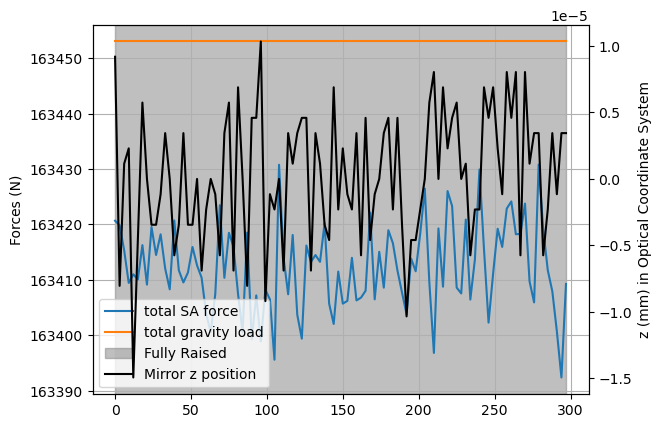

In [4]:
fig, ax1 = plt.subplots()

ax1.plot(tt-tt[0], (sa_force_z_total), label='total SA force') 
ax1.plot(tt-tt[0], (g_load[:,2]), label='total gravity load') 
#ax1.plot(tt-tt[0], ofl6[:,2],'r', label='outloop correction')
#ax1.invert_yaxis();

ymin, ymax = ax1.get_ylim()
true_indices = np.where(hold_idx == True)[0]
ax1.fill_betweenx(y=[ymin, ymax], x1=tt[true_indices[0]]-tt[0], x2=tt[true_indices[-1]]-tt[0], 
                  color='gray', alpha=0.5, label="Fully Raised")
ax1.set_ylim([ymin, ymax])
ax1.set_ylabel('Forces (N)')
ax2 = ax1.twinx()

ax2.plot(tt-tt[0], mirror_z[:,2]*1e3, '-k', label='Mirror z position');
ax2.set_xlabel('time (s)')
ax2.set_ylabel('z (mm) in Optical Coordinate System')
#ax2.legend()
#ax2.invert_yaxis();

# Merge legends from both axes
# Get handles and labels for both axes
handles, labels = [], []
handles.extend(ax1.get_legend_handles_labels()[0])
labels.extend(ax1.get_legend_handles_labels()[1])
handles.extend(ax2.get_legend_handles_labels()[0])
labels.extend(ax2.get_legend_handles_labels()[1])

# Create a single legend for both axes
ax1.legend(handles, labels)
ax1.grid();
#ax2.grid();
#ax1.legend()

#sa_force = sa_support_force + sa_bending_force
#sa_support_force = k_matrix(gravity_load + ofl_correction)
# blue is lower than orange we are using less force than we thought needed 
#i.e., mirror is lighter than expected, but this is only a few kg total!

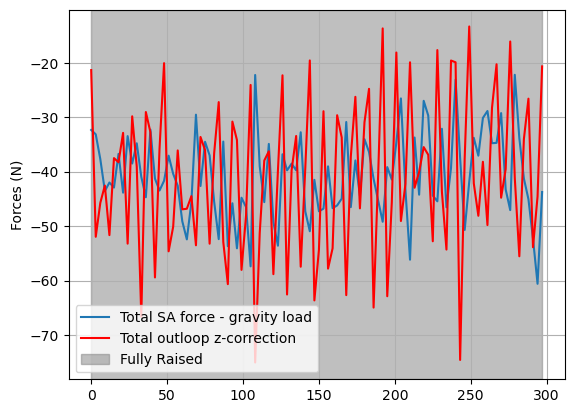

In [5]:
fig, ax1 = plt.subplots()

ax1.plot(tt-tt[0], (sa_force_z_total-g_load[:,2]), label='Total SA force - gravity load') 
ax1.plot(tt-tt[0], ofl6[:,2],'r', label='Total outloop z-correction')
#ax1.invert_yaxis();

ymin, ymax = ax1.get_ylim()
true_indices = np.where(hold_idx == True)[0]
ax1.fill_betweenx(y=[ymin, ymax], x1=tt[true_indices[0]]-tt[0], x2=tt[true_indices[-1]]-tt[0], 
                  color='gray', alpha=0.5, label="Fully Raised")
ax1.set_ylim([ymin, ymax])
ax1.set_ylabel('Forces (N)')

# Create a single legend for both axes
ax1.legend()
ax1.grid();
#ax2.grid();
#ax1.legend()

input forces and output figure both in Optical Coordinate System (OCS)


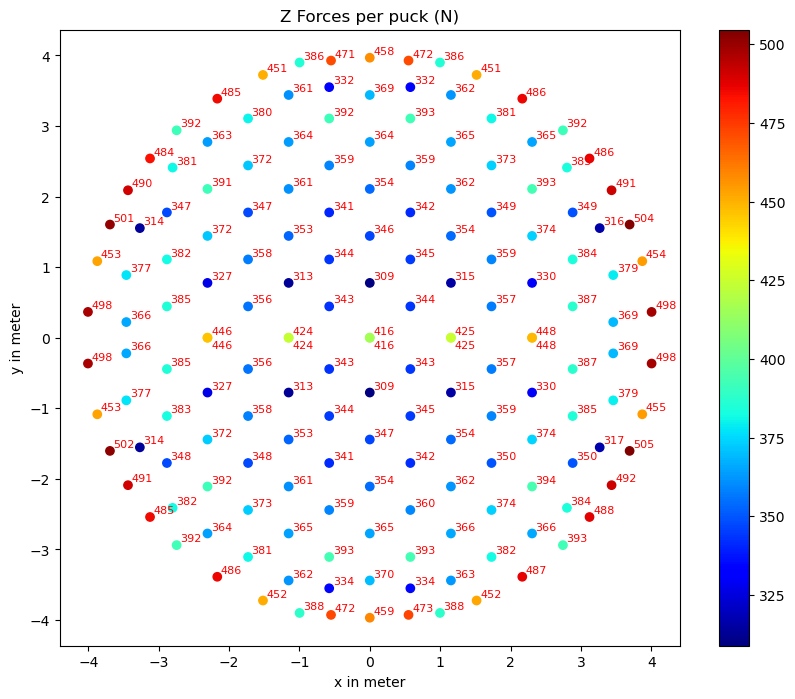

In [6]:
showForceMap(hold_force_per_puck, 'Z Forces per puck (N)')
#input force set already averaged over time.

### Compare to forces in Steve West's table

In [7]:
dataFolder = '../model_data/'
df = pd.read_excel(dataFolder+'gmt3_final_forces_english.xlsx', skiprows=2)
nact_sw = len(df)
print('Number of actuators = ', nact_sw)

sax_sw = np.array(df['y_opt (in)'])*in2mm/1000 #swap x/y to get to M1B (M1DCS uses M1B!!!)
say_sw = np.array(df['x_opt (in)'])*in2mm/1000
f_FEM = np.array(df['f_FEM (lbs)'])*lbs2N
f_active = np.array(df['f_active (lbs)'])*lbs2N
f_quad = np.array(df['newquad_corr (lbs)'])*lbs2N
f_corr = np.array(df['gmto_zfrc (lbs)'])*lbs2N
saID_sw_q = np.array(df['act #']) #steve west assigned these IDs, whether they are same as Trupti's is Questionable

Number of actuators =  170


input forces and output figure both in Optical Coordinate System (OCS)
mirror mass at acceptance (kg) 16181.484604234143
mirror mass now (kg)           16663.14932391521
diff (kg)  =  481.66471968106816
gravity load in DCS =  16667.30241


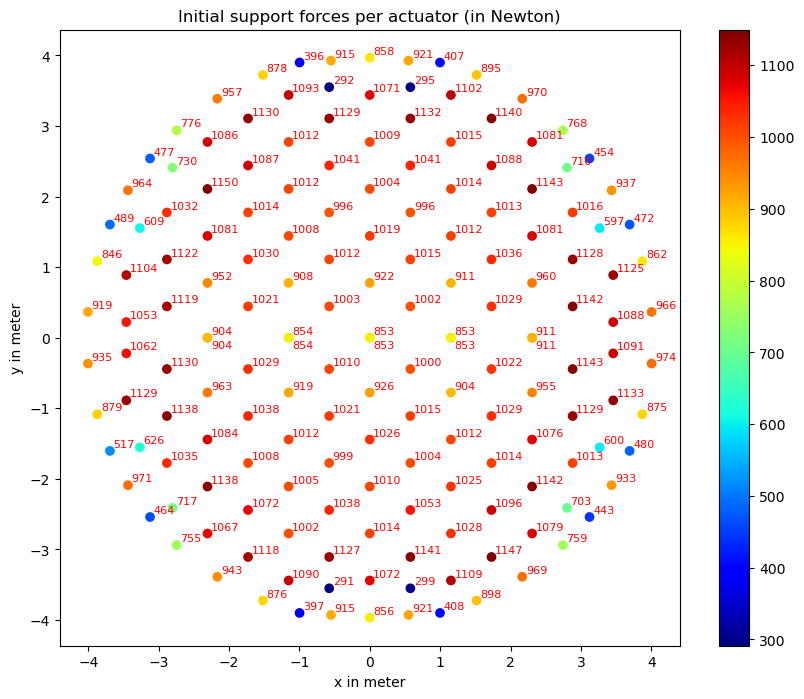

In [8]:
aa = swFvec2gmtFvec(f_corr)
#sw forces are positive, so they are already in the ocs
showForceMap(aa, 'Initial support forces per actuator (in Newton)')
mass_polish = np.sum(aa)*N2kg
print('mirror mass at acceptance (kg)',mass_polish)
mass_now = np.sum(np.mean(hold_force, axis=0)[:,2])*N2kg
print('mirror mass now (kg)          ', mass_now)
print('diff (kg)  = ', mass_now - mass_polish)
print('gravity load in DCS = ', g_load[0,2]*N2kg )

input forces and output figure both in Optical Coordinate System (OCS)


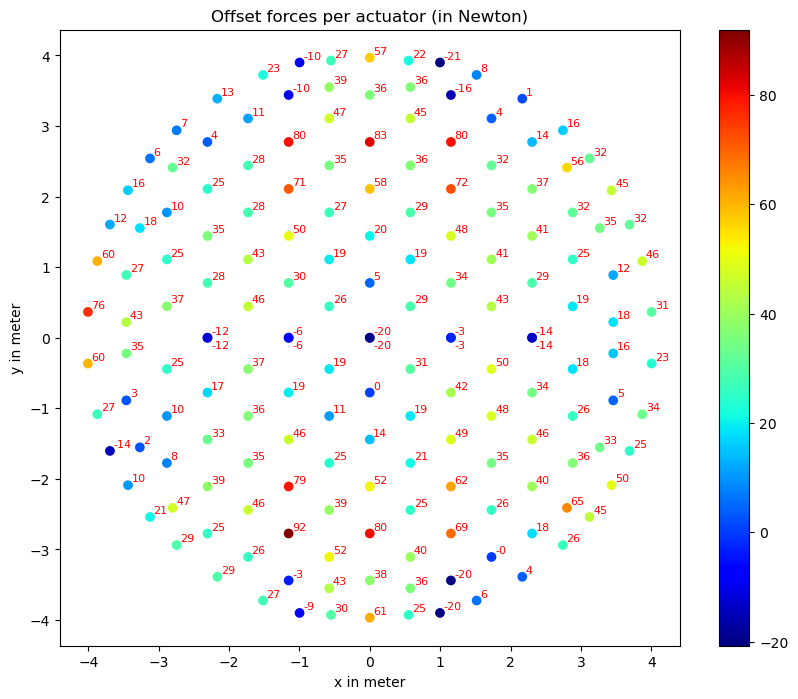

In [9]:
#positive means we need more forces to raise/hold
f_offset = np.mean(hold_force, axis=0)[:,2]-swFvec2gmtFvec(f_corr) 
showForceMap(f_offset, 'Offset forces per actuator (in Newton)')

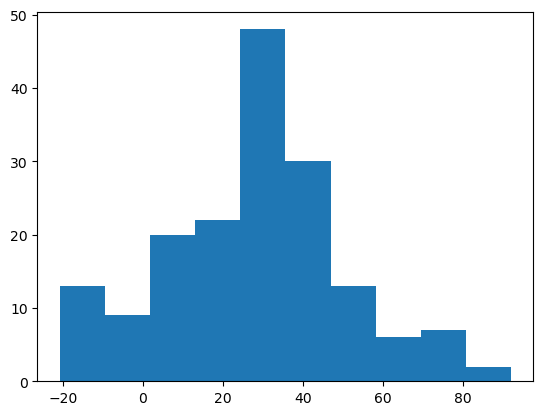

In [10]:
plt.hist(f_offset);

input forces and output figure both in Optical Coordinate System (OCS)


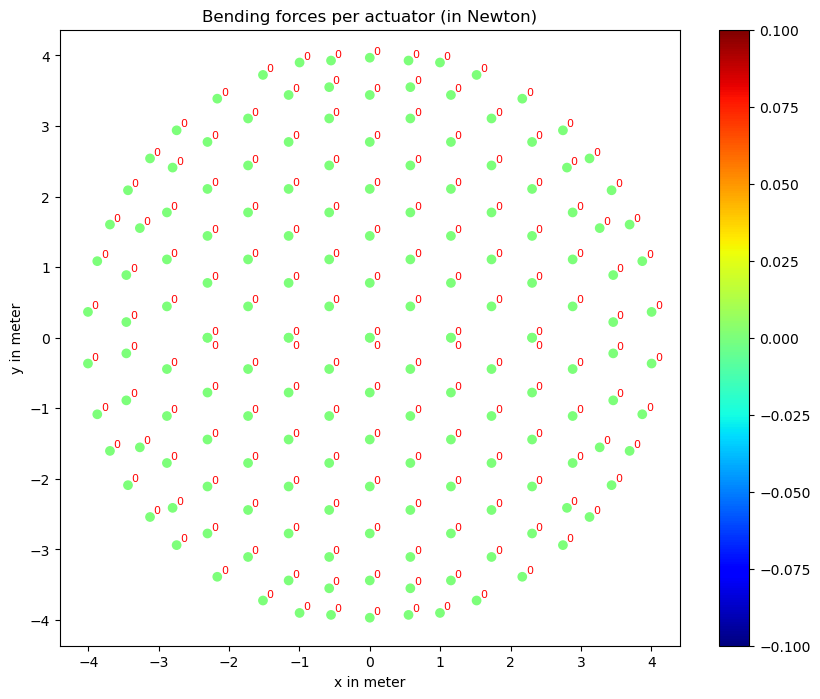

In [11]:
showForceMap(np.mean(bend_force,axis=0)[:,2], 'Bending forces per actuator (in Newton)')

### use this data to check humidity

In [12]:
dewpoint, tt = getDBData(start_time,'m1_s1_support_ctrl/i/iss_supply_dewpoint/value', duration_in_s=duration, samples=100)

m1_s1_support_ctrl/i/iss_supply_dewpoint/value
2024-11-21 11:19:23  duration =  300  s
(100,)


Text(0.5, 1.0, 'm1_s1_support_ctrl/i/iss_supply_dewpoint/value')

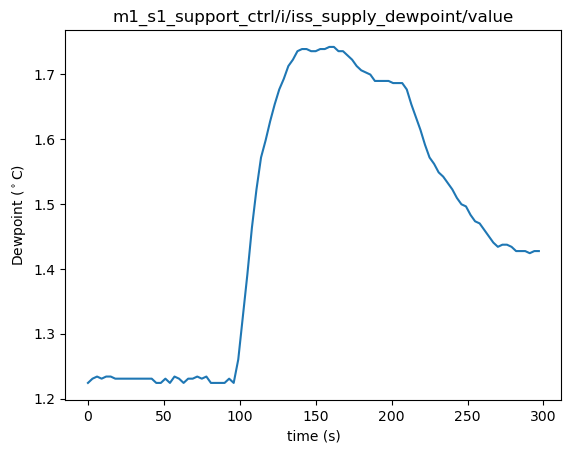

In [13]:
plt.plot(tt-tt[0],dewpoint)
plt.xlabel('time (s)')
plt.ylabel(r"Dewpoint ($^\circ\mathrm{C}$)")
plt.title('m1_s1_support_ctrl/i/iss_supply_dewpoint/value')
#relative humidity depends on water vapor amount & temperature
#due point depends only on water vapor amount